# Tree Based Model Practice
## Key Points
### 1 - Decision Tree simple model example with Tree View, recursive partition algrithm visulization
### 2 - Measure of Impurity
### 3 - Bagging and Random Forest
### 4 - Xgboost
### 5 - Grid Search

Import required Python packages.

In [15]:
import math
import os
import random
from pathlib import Path
from collections import defaultdict
from itertools import product


import pandas as pd
import numpy as np

from sklearn import preprocessing
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from xgboost import XGBClassifier

import pydotplus
from dmba import plotDecisionTree, textDecisionTree

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import matplotlib
%matplotlib inline

Define paths to data sets. If you don't keep your data in the same directory as the code, adapt the path names.

In [16]:
DATA = Path('.').resolve().parents[1] / 'Class3/treepractice'
DATA

WindowsPath('C:/Users/johnn/Desktop/github/DataScienceProgram/Class3/treepractice')

In [17]:
LOAN3000_CSV = DATA / 'loan3000.csv'
LOAN_DATA_CSV = DATA / 'loan_data.csv.gz'

# Tree Models
## A simple tree with visulization
The package _scikit-learn_ has the class `DecisionTreeClassifier` to build a decision tree model. The function `plotDecisionTree` from the _dmba_ package can be used to visualize the tree. 

##### Fit the tree model

In [18]:
loan3000 = pd.read_csv(LOAN3000_CSV)

predictors = ['borrower_score', 'payment_inc_ratio']
outcome = 'outcome'

X = loan3000[predictors]
y = loan3000[outcome]

loan_tree = DecisionTreeClassifier(random_state=1, criterion='entropy',
                                   min_impurity_decrease=0.003)
loan_tree.fit(X, y)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.003, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=1, splitter='best')

##### Use exisitng module from dmba package for visulization

In [19]:
plotDecisionTree(loan_tree, feature_names=predictors, class_names=loan_tree.classes_)

InvocationException: GraphViz's executables not found

##### Use SKlearn module and image to visulize 

In [ ]:
from sklearn import tree
from IPython.display import Image 
# Create DOT data
dot_data = tree.export_graphviz(loan_tree, out_file=None, 
                                feature_names=predictors,  
                                class_names=loan_tree.classes_)

# Draw graph
graph = pydotplus.graph_from_dot_data(dot_data)  

# Show graph
Image(graph.create_png())

## The Recursive Partitioning Algorithm and Tree example display the Algorithm
The data is repeatedly partitioned using predictor values which could do the best job of separating the data into relatively homogeneous partitions respect to target

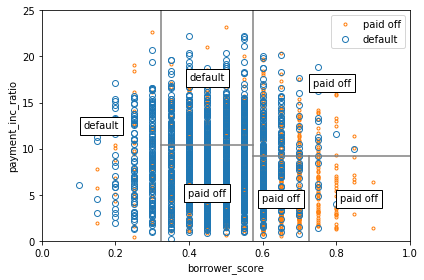

In [20]:
fig, ax = plt.subplots(figsize=(6, 4))

loan3000.loc[loan3000.outcome=='paid off'].plot(
    x='borrower_score', y='payment_inc_ratio', style='.', 
    markerfacecolor='none', markeredgecolor='C1', ax=ax)
loan3000.loc[loan3000.outcome=='default'].plot(
    x='borrower_score', y='payment_inc_ratio', style='o', 
    markerfacecolor='none', markeredgecolor='C0', ax=ax)
ax.legend(['paid off', 'default']);
ax.set_xlim(0, 1)
ax.set_ylim(0, 25)
ax.set_xlabel('borrower_score')
ax.set_ylabel('payment_inc_ratio')

x0 = 0.575
x1a = 0.325; y1b = 9.191
y2a = 10.423; x2b = 0.725
ax.plot((x0, x0), (0, 25), color='grey')
ax.plot((x1a, x1a), (0, 25), color='grey')
ax.plot((x0, 1), (y1b, y1b), color='grey')
ax.plot((x1a, x0), (y2a, y2a), color='grey')
ax.plot((x2b, x2b), (0, y1b), color='grey')

labels = [('default', (x1a / 2, 25 / 2)),
          ('default', ((x0 + x1a) / 2, (25 + y2a) / 2)),
          ('paid off', ((x0 + x1a) / 2, y2a / 2)),
          ('paid off', ((1 + x0) / 2, (y1b + 25) / 2)),
          ('paid off', ((1 + x2b) / 2, (y1b + 0) / 2)),
          ('paid off', ((x0 + x2b) / 2, (y1b + 0) / 2)),
         ]
for label, (x, y) in labels:
    ax.text(x, y, label, bbox={'facecolor':'white'},
            verticalalignment='center', horizontalalignment='center')

plt.tight_layout()
plt.show()

## Measuring Homogeneity or Impurity

In [21]:
def entropyFunction(x):
    if x == 0: return 0
    return -x * math.log(x, 2) - (1 - x) * math.log(1 - x, 2)

def giniFunction(x):
    return x * (1 - x)

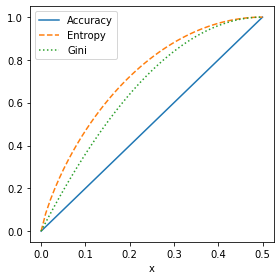

In [22]:
x = np.linspace(0, 0.5, 50)
impure = pd.DataFrame({
    'x': x,
    'Accuracy': 2 * x,
    'Gini': [giniFunction(xi) / giniFunction(.5) for xi in x],
    'Entropy': [entropyFunction(xi) for xi in x],
})

fig, ax = plt.subplots(figsize=(4, 4))

impure.plot(x='x', y='Accuracy', ax=ax, linestyle='solid')
impure.plot(x='x', y='Entropy', ax=ax, linestyle='--')
impure.plot(x='x', y='Gini', ax=ax, linestyle=':')

plt.tight_layout()
plt.show()

# Bagging and the Random Forest
## Random Forest

#### Fit a simple random forest model

In [23]:
predictors = ['borrower_score', 'payment_inc_ratio']
outcome = 'outcome'

X = loan3000[predictors]
y = loan3000[outcome]

rf = RandomForestClassifier(n_estimators=500, random_state=1, 
                            oob_score=True)
rf.fit(X, y)
print(rf.oob_decision_function_)
print(rf.oob_score_)

[[0.18131868 0.81868132]
 [0.26704545 0.73295455]
 [0.93333333 0.06666667]
 ...
 [1.         0.        ]
 [0.73157895 0.26842105]
 [0.68085106 0.31914894]]
0.5753333333333334


In [24]:
n_estimator = list(range(20, 510, 5))
oobScores = []
for n in n_estimator:
    rfc = RandomForestClassifier(n_estimators=n, 
                                criterion='entropy', max_depth=5,
                                random_state=1, oob_score=True)
    rfc.fit(X, y)
    oobScores.append(rfc.oob_score_)

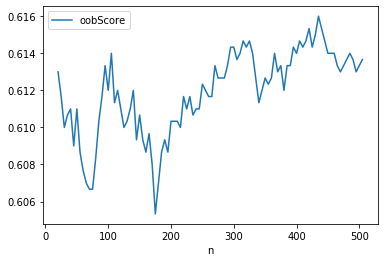

In [25]:
pd.DataFrame({
    'n': n_estimator, 
    'oobScore': oobScores
}).plot(x='n', y='oobScore')

## HomeWork1
#### 1 - Please recreate the above chart using testing dataset which created through train-test spliting
#### 2 - Please compare the result between OOB score and test score

In [26]:
from sklearn.metrics import roc_auc_score
loan3000_2=loan3000.copy()
loan3000_2['dv'] = [1 if out=="default" else 0 for out in loan3000['outcome']]


predictors = ['borrower_score', 'payment_inc_ratio']
outcome = 'dv'

# prepare train-test split
X = loan3000_2[predictors]
y = loan3000_2[outcome]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

n_estimator = list(range(20, 510, 5))
testScores = []

for n in n_estimator:
    rfc = RandomForestClassifier(n_estimators=n, random_state=1)
    rfc.fit(X_train, y_train)

    # predictions
    auc=roc_auc_score(y_test, rfc.predict(X_test), average='macro')
    testScores.append(auc)
    #print(n,auc, sum(y_test), sum(rfc.predict(X_test)))

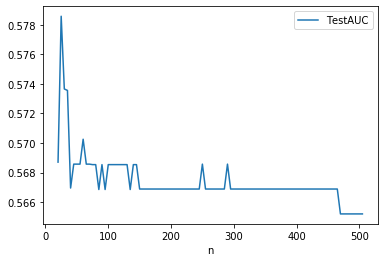

In [27]:
pd.DataFrame({
    'n': n_estimator, 
    'TestAUC': testScores
}).plot(x='n', y='TestAUC')

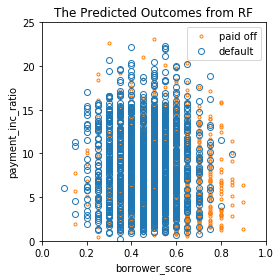

In [28]:
predictions = X.copy()
predictions['prediction'] = rf.predict(X)
predictions.head()

fig, ax = plt.subplots(figsize=(4, 4))

predictions.loc[predictions.prediction=='paid off'].plot(
    x='borrower_score', y='payment_inc_ratio', style='.',
    markerfacecolor='none', markeredgecolor='C1', ax=ax)
predictions.loc[predictions.prediction=='default'].plot(
    x='borrower_score', y='payment_inc_ratio', style='o',
    markerfacecolor='none', markeredgecolor='C0', ax=ax)
ax.legend(['paid off', 'default']);
ax.set_xlim(0, 1)
ax.set_ylim(0, 25)
ax.set_xlabel('borrower_score')
ax.set_ylabel('payment_inc_ratio')

plt.title("The Predicted Outcomes from RF")
plt.tight_layout()
plt.show()

#### Random forest overfitting can be observed

## Variable importance
This is different to R. The accuracy decrease is not available out of the box.

In [29]:
loan_data = pd.read_csv(LOAN_DATA_CSV)
loan_data = loan_data.drop(columns=['Unnamed: 0', 'status'])
loan_data['outcome'] = pd.Categorical(loan_data['outcome'], 
                                      categories=['paid off', 'default'], 
                                      ordered=True)

In [30]:
predictors = ['loan_amnt', 'term', 'annual_inc', 'dti', 
              'payment_inc_ratio', 'revol_bal', 'revol_util', 
              'purpose', 'delinq_2yrs_zero', 'pub_rec_zero', 
              'open_acc', 'grade', 'emp_length', 'purpose_', 
              'home_', 'emp_len_', 'borrower_score']
outcome = 'outcome'

X = pd.get_dummies(loan_data[predictors], drop_first=True)
y = loan_data[outcome]

rf_all = RandomForestClassifier(n_estimators=200, random_state=1)
rf_all.fit(X, y)
print(rf_all.fit(X, y))

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=1, verbose=0,
                       warm_start=False)


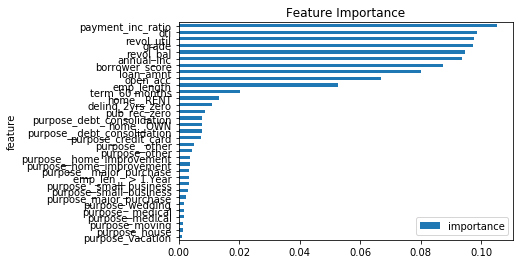

In [31]:
df = pd.DataFrame({
    'feature': X.columns, 
    'importance': rf_all.feature_importances_
})
df = df.sort_values('importance')

ax = df.plot(kind='barh', x='feature', y='importance', 
             title="Feature Importance")

plt.show()

# Boosting
## XGBoost

In [32]:
predictors = ['borrower_score', 'payment_inc_ratio']
outcome = 'outcome'

X = loan3000[predictors]
y = loan3000[outcome]

xgb = XGBClassifier(objective='binary:logistic', subsample=.63)
print(xgb.fit(X, y))

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=0.63, verbosity=1)


In [33]:
xgb_df = X.copy()
xgb_df['prediction'] = xgb.predict(X)
xgb_df['prob_default'] = xgb.predict_proba(X)[:, 0]
print(xgb_df.head())

   borrower_score  payment_inc_ratio prediction  prob_default
0            0.40            5.11135   paid off      0.439195
1            0.40            5.43165    default      0.557564
2            0.70            9.23003   paid off      0.315249
3            0.40            2.33482   paid off      0.461870
4            0.45           12.10320    default      0.630166


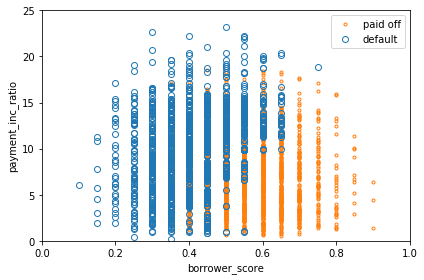

In [34]:
fig, ax = plt.subplots(figsize=(6, 4))

xgb_df.loc[xgb_df.prediction=='paid off'].plot(
    x='borrower_score', y='payment_inc_ratio', style='.', 
    markerfacecolor='none', markeredgecolor='C1', ax=ax)
xgb_df.loc[xgb_df.prediction=='default'].plot(
    x='borrower_score', y='payment_inc_ratio', style='o', 
    markerfacecolor='none', markeredgecolor='C0', ax=ax)
ax.legend(['paid off', 'default']);
ax.set_xlim(0, 1)
ax.set_ylim(0, 25)
ax.set_xlabel('borrower_score')
ax.set_ylabel('payment_inc_ratio')

plt.tight_layout()
plt.show()

## Regularization: Avoiding Overfitting

In [35]:
predictors = ['loan_amnt', 'term', 'annual_inc', 'dti', 
              'payment_inc_ratio', 'revol_bal', 'revol_util', 
              'purpose', 'delinq_2yrs_zero', 'pub_rec_zero', 
              'open_acc', 'grade', 'emp_length', 'purpose_', 
              'home_', 'emp_len_', 'borrower_score']
outcome = 'outcome'

X = pd.get_dummies(loan_data[predictors], drop_first=True)
y = pd.Series([1 if o == 'default' else 0 for o in loan_data[outcome]])

train_X, valid_X, train_y, valid_y = train_test_split(X, y, test_size=10000)

xgb_default = XGBClassifier(objective='binary:logistic', n_estimators=250, max_depth=6,
                            reg_lambda=0, learning_rate=0.3, subsample=1)
xgb_default.fit(train_X, train_y)

xgb_penalty = XGBClassifier(objective='binary:logistic', n_estimators=250, max_depth=6,
                            reg_lambda=1000, learning_rate=0.1, subsample=0.63, colsample_bytree=0.7)
print(xgb_penalty.fit(train_X, train_y))

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.7, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=None, n_estimators=250, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1000, scale_pos_weight=1, seed=None,
              silent=None, subsample=0.63, verbosity=1)


In [36]:
pred_default = xgb_default.predict_proba(train_X)[:, 1]
error_default = abs(train_y - pred_default) > 0.5
print('default (train): ', np.mean(error_default))

pred_default = xgb_default.predict_proba(valid_X)[:, 1]
error_default = abs(valid_y - pred_default) > 0.5
print('default: ', np.mean(error_default))

pred_penalty = xgb_penalty.predict_proba(valid_X)[:, 1]
error_penalty = abs(valid_y - pred_penalty) > 0.5
print('penalty: ', np.mean(error_penalty))

default (train):  0.11999886820213909
default:  0.3535
penalty:  0.3249


In [37]:
results = []
for ntree_limit in range(1, 250):
    train_default = xgb_default.predict_proba(train_X, ntree_limit=ntree_limit)[:, 1]
    train_penalty = xgb_penalty.predict_proba(train_X, ntree_limit=ntree_limit)[:, 1]
    pred_default = xgb_default.predict_proba(valid_X, ntree_limit=ntree_limit)[:, 1]
    pred_penalty = xgb_penalty.predict_proba(valid_X, ntree_limit=ntree_limit)[:, 1]
    results.append({
        'iterations': ntree_limit,
        'default train': np.mean(abs(train_y - train_default) > 0.5),
        'penalty train': np.mean(abs(train_y - train_penalty) > 0.5),
        'default test': np.mean(abs(valid_y - pred_default) > 0.5),
        'penalty test': np.mean(abs(valid_y - pred_penalty) > 0.5),
    })

results = pd.DataFrame(results)
print(results.head())

   iterations  default train  penalty train  default test  penalty test
0           1       0.338266       0.371145        0.3465        0.3816
1           2       0.329947       0.345481        0.3414        0.3473
2           3       0.327854       0.350829        0.3375        0.3516
3           4       0.323355       0.353800        0.3368        0.3547
4           5       0.320638       0.341067        0.3352        0.3441


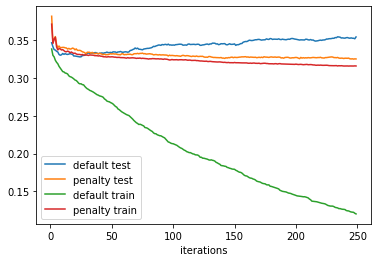

In [38]:
ax = results.plot(x='iterations', y='default test')
results.plot(x='iterations', y='penalty test', ax=ax)
results.plot(x='iterations', y='default train', ax=ax)
results.plot(x='iterations', y='penalty train', ax=ax)
plt.show()

## Hyperparameters and Cross-Validation

### Small scale grid search

In [39]:
idx = np.random.choice(range(5), size=len(X), replace=True)
error = []
for eta, max_depth in product([0.1, 0.5, 0.9], [3, 6, 9]):
    xgb = XGBClassifier(objective='binary:logistic', n_estimators=100, 
                        max_depth=max_depth, learning_rate=eta)
    cv_error = []
    for k in range(5):
        fold_idx = idx == k
        train_X = X.loc[~fold_idx]; train_y = y[~fold_idx]
        valid_X = X.loc[fold_idx]; valid_y = y[fold_idx]

        xgb.fit(train_X, train_y)
        pred = xgb.predict_proba(valid_X)[:, 1]
        cv_error.append(np.mean(abs(valid_y - pred) > 0.5))
    error.append({
        'eta': eta,
        'max_depth': max_depth,
        'avg_error': np.mean(cv_error)
    })
    print(error[-1])
errors = pd.DataFrame(error)
print(errors)

{'eta': 0.1, 'max_depth': 3, 'avg_error': 0.3303081641494588}
{'eta': 0.1, 'max_depth': 6, 'avg_error': 0.3323157663645063}
{'eta': 0.1, 'max_depth': 9, 'avg_error': 0.3378066904492843}
{'eta': 0.5, 'max_depth': 3, 'avg_error': 0.33262968491016387}
{'eta': 0.5, 'max_depth': 6, 'avg_error': 0.35109717259215334}
{'eta': 0.5, 'max_depth': 9, 'avg_error': 0.3729751353401072}
{'eta': 0.9, 'max_depth': 3, 'avg_error': 0.3441849148524497}
{'eta': 0.9, 'max_depth': 6, 'avg_error': 0.3752878647940118}
{'eta': 0.9, 'max_depth': 9, 'avg_error': 0.3838650291316673}
   eta  max_depth  avg_error
0  0.1          3   0.330308
1  0.1          6   0.332316
2  0.1          9   0.337807
3  0.5          3   0.332630
4  0.5          6   0.351097
5  0.5          9   0.372975
6  0.9          3   0.344185
7  0.9          6   0.375288
8  0.9          9   0.383865


In [40]:
print(errors.pivot_table(index='eta', columns='max_depth', values='avg_error') * 100)

max_depth          3          6          9
eta                                       
0.1        33.030816  33.231577  33.780669
0.5        33.262968  35.109717  37.297514
0.9        34.418491  37.528786  38.386503


## homework2: Could you extend the grid search to three or more parameters

In [41]:
idx = np.random.choice(range(5), size=len(X), replace=True)
error = []
for eta, max_depth, n_est in product([0.1, 0.5, 0.9], [3, 6, 9], [100, 300, 500]):
    xgb = XGBClassifier(objective='binary:logistic', n_estimators=n_est, 
                        max_depth=max_depth, learning_rate=eta)
    cv_error = []
    for k in range(5):
        fold_idx = idx == k
        train_X = X.loc[~fold_idx]; train_y = y[~fold_idx]
        valid_X = X.loc[fold_idx]; valid_y = y[fold_idx]

        xgb.fit(train_X, train_y)
        pred = xgb.predict_proba(valid_X)[:, 1]
        cv_error.append(np.mean(abs(valid_y - pred) > 0.5))
    error.append({
        'eta': eta,
        'max_depth': max_depth,
        'avg_error': np.mean(cv_error),
        'n_estimators': n_est
    })
    print(error[-1])
errors = pd.DataFrame(error)
print(errors)

{'eta': 0.1, 'max_depth': 3, 'avg_error': 0.33034999061912124, 'n_estimators': 100}
{'eta': 0.1, 'max_depth': 3, 'avg_error': 0.32983215018406437, 'n_estimators': 300}
{'eta': 0.1, 'max_depth': 3, 'avg_error': 0.33080402124294445, 'n_estimators': 500}
{'eta': 0.1, 'max_depth': 6, 'avg_error': 0.3331621147273888, 'n_estimators': 100}
{'eta': 0.1, 'max_depth': 6, 'avg_error': 0.3373338074229245, 'n_estimators': 300}
{'eta': 0.1, 'max_depth': 6, 'avg_error': 0.341095216757577, 'n_estimators': 500}
{'eta': 0.1, 'max_depth': 9, 'avg_error': 0.3398513997654187, 'n_estimators': 100}
{'eta': 0.1, 'max_depth': 9, 'avg_error': 0.34810458769776037, 'n_estimators': 300}
{'eta': 0.1, 'max_depth': 9, 'avg_error': 0.35203378916003947, 'n_estimators': 500}
{'eta': 0.5, 'max_depth': 3, 'avg_error': 0.33553701732451147, 'n_estimators': 100}
{'eta': 0.5, 'max_depth': 3, 'avg_error': 0.34336305931081146, 'n_estimators': 300}
{'eta': 0.5, 'max_depth': 3, 'avg_error': 0.3496302033568188, 'n_estimators': 500